In [1]:
import pandas as pd
import json
from pymongo import MongoClient
import pymongo
import luigi
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Data

In [2]:
#Load data from csv
df = pd.read_csv("Death_rates_for_suicide__by_sex__race__Hispanic_origin__and_age__United_States.csv")

In [3]:
#Transform data to json file save as data.json
df.to_json('C:/Users/Hilal/Desktop/NCI classes notes/Database and Analytics Programming/DAP project/data.json')

In [4]:
with open("data.json") as f:
    data = json.load(f)
    print(data)

{'INDICATOR': {'0': 'Death rates for suicide', '1': 'Death rates for suicide', '2': 'Death rates for suicide', '3': 'Death rates for suicide', '4': 'Death rates for suicide', '5': 'Death rates for suicide', '6': 'Death rates for suicide', '7': 'Death rates for suicide', '8': 'Death rates for suicide', '9': 'Death rates for suicide', '10': 'Death rates for suicide', '11': 'Death rates for suicide', '12': 'Death rates for suicide', '13': 'Death rates for suicide', '14': 'Death rates for suicide', '15': 'Death rates for suicide', '16': 'Death rates for suicide', '17': 'Death rates for suicide', '18': 'Death rates for suicide', '19': 'Death rates for suicide', '20': 'Death rates for suicide', '21': 'Death rates for suicide', '22': 'Death rates for suicide', '23': 'Death rates for suicide', '24': 'Death rates for suicide', '25': 'Death rates for suicide', '26': 'Death rates for suicide', '27': 'Death rates for suicide', '28': 'Death rates for suicide', '29': 'Death rates for suicide', '30':

In [16]:
df_dict = {}

# For data, creating a dictionary
for key, values_dict in data.items():
    df_dict[key] = list(values_dict.values())

# Creating a dataframe
df = pd.DataFrame(df_dict)

print(df)

                    INDICATOR  \
0     Death rates for suicide   
1     Death rates for suicide   
2     Death rates for suicide   
3     Death rates for suicide   
4     Death rates for suicide   
...                       ...   
6385  Death rates for suicide   
6386  Death rates for suicide   
6387  Death rates for suicide   
6388  Death rates for suicide   
6389  Death rates for suicide   

                                                   UNIT  UNIT_NUM  \
0     Deaths per 100,000 resident population, age-ad...         1   
1     Deaths per 100,000 resident population, age-ad...         1   
2     Deaths per 100,000 resident population, age-ad...         1   
3     Deaths per 100,000 resident population, age-ad...         1   
4     Deaths per 100,000 resident population, age-ad...         1   
...                                                 ...       ...   
6385      Deaths per 100,000 resident population, crude         2   
6386      Deaths per 100,000 resident population, c

## Saving Data into MongoDB

In [8]:
myclient = MongoClient("localhost", 27017)                    #Connection to MongoDB
db = myclient["Death_Rates_For_Suicide_db"]                   #Create a DataBase named Death_Rates_For_Suicide_db
collection = db['Death_Rates_For_Suicide_collection']         #Create a collection named Death_Rates_For_Suicide_collection

In [13]:
db.list_collection_names()

['Death_Rates_For_Suicide_collection']

In [18]:
# Create database and collection
db_name = "Death_Rates_For_Suicide_db"
collection_name = 'Death_Rates_For_Suicide_collection'
if db_name in myclient.list_database_names():
    print(f"databaes {db_name} is exist.")
else: 
    db = myclient[db_name]
    if collection_name in myclient.db.list_collection_names():
        print(f"Collection {collection_name} is exist.")
    else :
        collection = db[collection_name]

In [19]:
# Convert dataset to dictionary
dict_data = df.to_dict(orient="records")
# Insert data into mongo db
db[collection_name].insert_many(dict_data)

## ETL Process with Luigi

In [50]:
pip install luigi

Note: you may need to restart the kernel to use updated packages.


In [20]:
class LoadFromMongodb(luigi.Task):
    """
    A Luigi task to load data from MongoDB and write it to a CSV file
    """
    client = luigi.Parameter()
    database = luigi.Parameter()
    collection = luigi.Parameter()
    output_path = luigi.Parameter()

    def output(self):
        """
        Returns the target output for this task
        """
        return luigi.LocalTarget(self.output_path)

    def run(self):
        """
        Loads data from MongoDB and writes it to a CSV file
        """
        # connect to MongoDB
        with pymongo.MongoClient(self.client) as client:
            db = client[self.database]
            collection = db[self.collection]

            # load data from MongoDB and convert it to a DataFrame
            data = list(collection.find())
            df = pd.DataFrame(data)        

            # write the DataFrame to a CSV file
            df.to_csv(self.output_path, index=False)

In [23]:
if __name__ == '__main__':
    # Example usage:
    task = LoadFromMongodb(
        client="localhost",
        #port="27017",
        database="Death_Rates_For_Suicide_db",
        collection='Death_Rates_For_Suicide_collection',
        output_path="Death_Rates_For_Suicide_loaded_data.csv"
    )
    luigi.build([task], workers=1, local_scheduler=True)

DEBUG: Checking if LoadFromMongodb(client=localhost, database=Death_Rates_For_Suicide_db, collection=Death_Rates_For_Suicide_collection, output_path=Death_Rates_For_Suicide_loaded_data.csv) is complete
INFO: Informed scheduler that task   LoadFromMongodb_localhost_Death_Rates_For__Death_Rates_For__11439cf5c6   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 13220] Worker Worker(salt=6227534342, workers=1, host=DESKTOP-DJQE022, username=Hilal, pid=13220) running   LoadFromMongodb(client=localhost, database=Death_Rates_For_Suicide_db, collection=Death_Rates_For_Suicide_collection, output_path=Death_Rates_For_Suicide_loaded_data.csv)
INFO: [pid 13220] Worker Worker(salt=6227534342, workers=1, host=DESKTOP-DJQE022, username=Hilal, pid=13220) done      LoadFromMongodb(client=localhost, database=Death_Rates_For_Suicide_db, collection=Death_Rates_For_Suicide_collection, output_path=De

In [1]:
import pandas as pd 
df = pd.read_csv("Death_Rates_For_Suicide_loaded_data.csv")

In [2]:
df.head(3)

,_id,INDICATOR,UNIT,UNIT_NUM,STUB_NAME,STUB_NAME_NUM,STUB_LABEL,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE,AGE_NUM,ESTIMATE,FLAG
0,660b3ccb2d3da7b528bc5f4d,Death rates for suicide,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.0,1950,1,All ages,0.0,13.2,NaN
1,660b3ccb2d3da7b528bc5f4e,Death rates for suicide,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.0,1960,2,All ages,0.0,12.5,NaN
2,660b3ccb2d3da7b528bc5f4f,Death rates for suicide,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.0,1970,3,All ages,0.0,13.1,NaN


In [3]:
df.describe()

,UNIT_NUM,STUB_NAME_NUM,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE_NUM,ESTIMATE
count,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,5484.000000
mean,1.872926,4.621909,4.686775,1997.525822,22.692019,2.712207,13.709810
std,0.333081,2.031777,1.829624,14.937451,12.286033,1.932280,11.531805
min,1.000000,0.000000,0.000000,1950.000000,1.000000,0.000000,0.300000
25%,2.000000,3.000000,3.230000,1988.000000,12.000000,0.000000,5.000000
50%,2.000000,5.000000,5.125100,1999.000000,23.000000,3.000000,10.500000
75%,2.000000,6.000000,6.153000,2009.000000,33.000000,4.100000,19.500000
max,2.000000,11.000000,7.235000,2018.000000,42.000000,6.000000,74.800000


## Creating Gender column

In [3]:
def gender(df):
    # In order to find male and female strings in 'STUB_LABEL' column, regex is used. 
    male_filter = df['STUB_LABEL'].str.contains(r'\bmale\b', case=False)
    female_filter = df['STUB_LABEL'].str.contains(r'\bfemale\b', case=False)
    
    # Creating "Gender" columns and if it is male than value is 1, otherwise is 0.
    df['GENDER'] = 0
    df.loc[male_filter, 'GENDER'] = 1
    return df

gender(df)

,_id,INDICATOR,UNIT,UNIT_NUM,STUB_NAME,STUB_NAME_NUM,STUB_LABEL,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE,AGE_NUM,ESTIMATE,FLAG,GENDER
0,660b3ccb2d3da7b528bc5f4d,Death rates for suicide,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.000,1950,1,All ages,0.0,13.2,NaN,0
1,660b3ccb2d3da7b528bc5f4e,Death rates for suicide,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.000,1960,2,All ages,0.0,12.5,NaN,0
2,660b3ccb2d3da7b528bc5f4f,Death rates for suicide,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.000,1970,3,All ages,0.0,13.1,NaN,0
3,660b3ccb2d3da7b528bc5f50,Death rates for suicide,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.000,1980,4,All ages,0.0,12.2,NaN,0
4,660b3ccb2d3da7b528bc5f51,Death rates for suicide,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.000,1981,5,All ages,0.0,12.3,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6385,660b3ccb2d3da7b528bc783e,Death rates for suicide,"Deaths per 100,000 resident population, crude",2,"Sex, age and race and Hispanic origin (Single ...",11,Female: Not Hispanic or Latino: Black or Afric...,7.225,2018,42,65 years and over,5.0,1.3,NaN,0
6386,660b3ccb2d3da7b528bc783f,Death rates for suicide,"Deaths per 100,000 resident population, crude",2,"Sex, age and race and Hispanic origin (Single ...",11,Female: Hispanic or Latino: All races: 15-24 y...,7.232,2018,42,15-24 years,2.0,4.1,NaN,0
6387,660b3ccb2d3da7b528bc7840,Death rates for suicide,"Deaths per 100,000 resident population, crude",2,"Sex, age and race and Hispanic origin (Single ...",11,Female: Hispanic or Latino: All races: 25-44 y...,7.233,2018,42,25-44 years,3.0,4.4,NaN,0
6388,660b3ccb2d3da7b528bc7841,Death rates for suicide,"Deaths per 100,000 resident population, crude",2,"Sex, age and race and Hispanic origin (Single ...",11,Female: Hispanic or Latino: All races: 45-64 y...,7.234,2018,42,45-64 years,4.0,3.2,NaN,0


## Dealing with missing values

In [4]:
# Missing observations check
df.isnull().sum()

_id                  0
INDICATOR            0
UNIT                 0
UNIT_NUM             0
STUB_NAME            0
STUB_NAME_NUM        0
STUB_LABEL           0
STUB_LABEL_NUM       0
YEAR                 0
YEAR_NUM             0
AGE                  0
AGE_NUM              0
ESTIMATE           906
FLAG              5484
GENDER               0
dtype: int64

In [5]:
# Filling ESTIMATE's missing values with mean of ESTIMATE
df["ESTIMATE"]= df["ESTIMATE"].fillna(df["ESTIMATE"].mean()) 

In [6]:
df.isnull().sum()

_id                  0
INDICATOR            0
UNIT                 0
UNIT_NUM             0
STUB_NAME            0
STUB_NAME_NUM        0
STUB_LABEL           0
STUB_LABEL_NUM       0
YEAR                 0
YEAR_NUM             0
AGE                  0
AGE_NUM              0
ESTIMATE             0
FLAG              5484
GENDER               0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6390 entries, 0 to 6389
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _id             6390 non-null   object 
 1   INDICATOR       6390 non-null   object 
 2   UNIT            6390 non-null   object 
 3   UNIT_NUM        6390 non-null   int64  
 4   STUB_NAME       6390 non-null   object 
 5   STUB_NAME_NUM   6390 non-null   int64  
 6   STUB_LABEL      6390 non-null   object 
 7   STUB_LABEL_NUM  6390 non-null   float64
 8   YEAR            6390 non-null   int64  
 9   YEAR_NUM        6390 non-null   int64  
 10  AGE             6390 non-null   object 
 11  AGE_NUM         6390 non-null   float64
 12  ESTIMATE        6390 non-null   float64
 13  FLAG            906 non-null    object 
 14  GENDER          6390 non-null   int64  
dtypes: float64(3), int64(5), object(7)
memory usage: 749.0+ KB


In [29]:
df.drop(columns=["FLAG","UNIT","STUB_NAME","STUB_LABEL","AGE","INDICATOR"], inplace=True)

In [30]:
df.head(3)

,_id,UNIT_NUM,STUB_NAME_NUM,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE_NUM,ESTIMATE,GENDER
0,660b3ccb2d3da7b528bc5f4d,1,0,0.0,1950,1,0.0,13.2,0
1,660b3ccb2d3da7b528bc5f4e,1,0,0.0,1960,2,0.0,12.5,0
2,660b3ccb2d3da7b528bc5f4f,1,0,0.0,1970,3,0.0,13.1,0


## Outliers Checking 

In [9]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    '''
    Outlier Thresholds function define lower and upper limits to detect outlier values
    in a given DataFrame. Quartile1 (q1) and Quartile3(q2) can be changed by the user.
    It returns lower and upper limits based on the interquartile method (IQR).
    '''
    # Check if the column is numerical
    if dataframe[col_name].dtype != "float64" and dataframe[col_name].dtype != "int64":
        return "Column is not numerical!"
    
    # Calculate the quartiles and interquartile range
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    
    # Calculate the upper and lower limits
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    '''
    Check Outlier function detects outlier values in a given DataFrame.
    It shows True if there are outlier values in a column, otherwise not.
    '''
    # Check if the column is numerical
    if dataframe[col_name].dtype != "float64" and dataframe[col_name].dtype != "int64":
        return "Column is not numerical!"
    
    # Get the lower and upper limits for outliers
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    
    # Check if there are outliers
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [31]:
for col in df.columns:
    print(col, check_outlier(df, col))

_id Column is not numerical!
UNIT_NUM False
STUB_NAME_NUM False
STUB_LABEL_NUM False
YEAR False
YEAR_NUM False
AGE_NUM False
ESTIMATE False
GENDER False


In [32]:
df["STUB_LABEL_NUM"] = df["STUB_LABEL_NUM"].astype(float)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6390 entries, 0 to 6389
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _id             6390 non-null   object 
 1   UNIT_NUM        6390 non-null   int64  
 2   STUB_NAME_NUM   6390 non-null   int64  
 3   STUB_LABEL_NUM  6390 non-null   float64
 4   YEAR            6390 non-null   int64  
 5   YEAR_NUM        6390 non-null   int64  
 6   AGE_NUM         6390 non-null   float64
 7   ESTIMATE        6390 non-null   float64
 8   GENDER          6390 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 449.4+ KB


In [15]:
df.head(5)

,_id,UNIT_NUM,STUB_NAME_NUM,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE_NUM,ESTIMATE,GENDER
0,660b3ccb2d3da7b528bc5f4d,1,0,0.0,1950,1,0.0,13.2,0
1,660b3ccb2d3da7b528bc5f4e,1,0,0.0,1960,2,0.0,12.5,0
2,660b3ccb2d3da7b528bc5f4f,1,0,0.0,1970,3,0.0,13.1,0
3,660b3ccb2d3da7b528bc5f50,1,0,0.0,1980,4,0.0,12.2,0
4,660b3ccb2d3da7b528bc5f51,1,0,0.0,1981,5,0.0,12.3,0


In [104]:
#Saving Cleaned data as cleaned_data.csv

df.to_csv('cleaned_data.csv', index=False)

## Saving Cleaned Data into PostgreSQL

In [110]:
import psycopg2

conn = psycopg2.connect(database="postgres",
                        host="localhost",
                        user="postgres",
                        password="abcde",
                        port="5432")
conn.autocommit = True
cursor = conn.cursor()

# create a database
query = '''CREATE Database death_db'''
try: 
    cursor.execute(query)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

In [111]:
# create a table
conn = psycopg2.connect(database="death_db",
                        host="localhost",
                        user="postgres",
                        password="abcde",
                        port="5432")
cursor = conn.cursor()

    
query ='''CREATE TABLE death_db(_id CHAR(50),
UNIT_NUM INT,
STUB_NAME_NUM INT,
STUB_LABEL_NUM FLOAT,
YEAR INT,
YEAR_NUM INT,
AGE_NUM FLOAT,
ESTIMATE FLOAT,
GENDER INT)'''
try:
    cursor.execute(query)
    conn.commit()
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

In [112]:
# Connection to PostgreSQL
conn = psycopg2.connect(user = "postgres",
        password = "abcde",
        host = "127.0.0.1",
        port = "5432",
        database = "death_db")
cursor = conn.cursor()

# Transfer to data with copy
with open('cleaned_data.csv', 'r') as f:
    next(f)  # Skip Header
    cursor.copy_from(f, 'death_db', sep=',', columns=('_id','unit_num','stub_name_num', 'stub_label_num', 'year', 'year_num', 'age_num', 'estimate', 'gender'))
    conn.commit()

# Connection Close
conn.close()


## Visualization

In [7]:
df['GENDER'].value_counts()    #male:1, female:0

GENDER
0    3403
1    2987
Name: count, dtype: int64

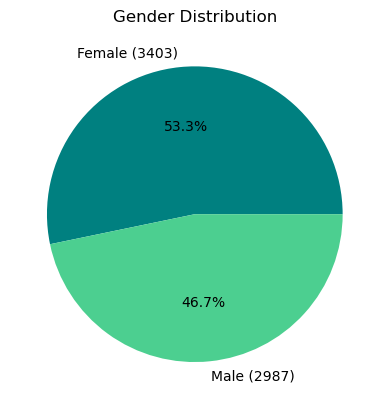

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

gender_distribution = df["GENDER"].value_counts()             
plt.pie(gender_distribution, labels=[f'Female ({gender_distribution[0]})', f'Male ({gender_distribution[1]})'], colors=['#008080', "#4CCF90"], autopct='%1.1f%%')  
plt.title('Gender Distribution')
plt.show()

In [8]:
df.groupby("GENDER").agg({"ESTIMATE": "mean"})

,ESTIMATE
GENDER,
0,8.026279
1,20.184888


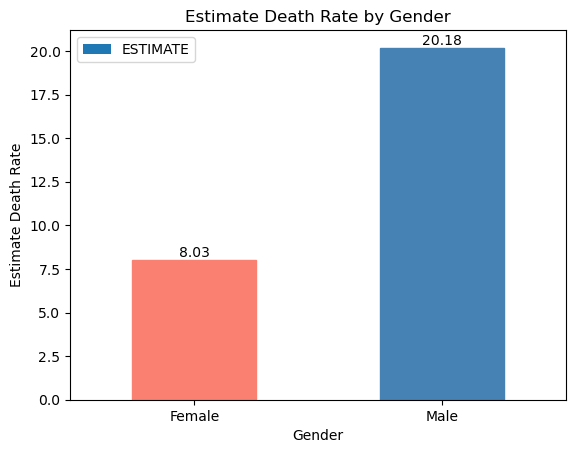

In [20]:
mean_estimate_by_gender = df.groupby("GENDER").agg({"ESTIMATE": "mean"})
ax = mean_estimate_by_gender.plot(kind='bar')

# Colors
colors = ["salmon", "steelblue"]

# Applying color to bars
for i, bar in enumerate(ax.patches):
    bar.set_color(colors[i])

# Labels
ax.set_xticklabels(['Female', 'Male'], rotation=0)

# Adding death rates for bars
for i, val in enumerate(mean_estimate_by_gender["ESTIMATE"].values):
    ax.text(i, val, round(val, 2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':10})

plt.title('Estimate Death Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Estimate Death Rate')
plt.show()

In [63]:
100 * df["GENDER"].value_counts() / len(df)

GENDER
0    53.255086
1    46.744914
Name: count, dtype: float64

In [56]:
df['AGE'].value_counts() 

AGE
All ages             1624
15-24 years           812
25-44 years           812
45-64 years           812
65 years and over     812
65-74 years           212
75-84 years           212
85 years and over     212
10-14 years           126
15-19 years           126
20-24 years           126
25-34 years           126
35-44 years           126
45-54 years           126
55-64 years           126
Name: count, dtype: int64

In [16]:
df.groupby("AGE").agg({"ESTIMATE": "mean"})

,ESTIMATE
AGE,
10-14 years,1.616029
15-19 years,8.648413
15-24 years,12.451421
20-24 years,13.757937
25-34 years,14.323810
25-44 years,13.656217
35-44 years,15.565873
45-54 years,17.075397
45-64 years,12.896454


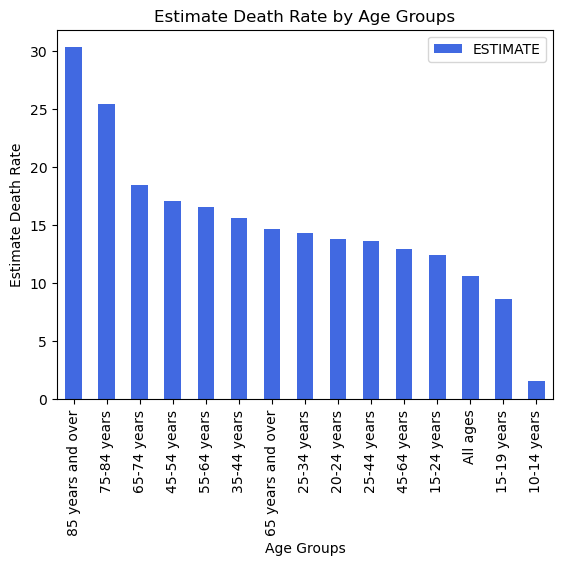

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

mean_estimate_by_age = df.groupby("AGE").agg({"ESTIMATE": "mean"})
mean_estimate_by_age_sorted = mean_estimate_by_age.sort_values(by='ESTIMATE', ascending=False)

mean_estimate_by_age_sorted.plot(kind='bar', color="royalblue")
plt.title('Estimate Death Rate by Age Groups')
plt.xlabel('Age Groups')
plt.ylabel('Estimate Death Rate')
plt.show()

In [26]:
df.groupby(["AGE","GENDER"]).agg({"ESTIMATE": "mean"})

ESTIMATE
AGE               GENDER           
10-14 years       0        1.130488
                  1        1.988095
15-19 years       0        6.077381
                  1       13.790476
15-24 years       0        5.449422
                  1       19.308232
20-24 years       0        9.115476
                  1       23.042857
25-34 years       0        9.997619
                  1       22.976190
25-44 years       0        6.771038
                  1       21.296657
35-44 years       0       11.467857
                  1       23.761905
45-54 years       0       12.804762
                  1       25.616667
45-64 years       0        7.173353
                  1       18.424149
55-64 years       0       11.889286
                  1       25.957143
65 years and over 0        6.551408
                  1       23.655674
65-74 years       0       10.896429
                  1       23.454687
75-84 years       0       12.588095
                  1       34.286400
85 years and over 0       12.195238
                  1       56.551765
All ages          0        5.101859
                  1       15.939013

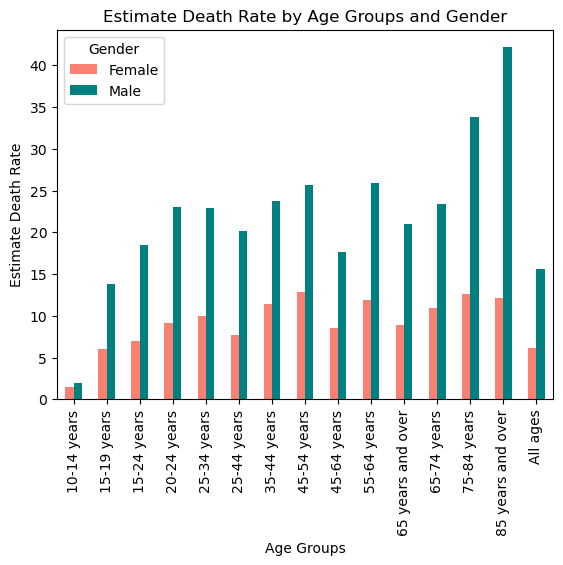

In [27]:
# Pivot the DataFrame
pivot_df = df.pivot_table(index='AGE', columns='GENDER', values='ESTIMATE', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', color=["salmon", "teal"])
plt.title('Estimate Death Rate by Age Groups and Gender')
plt.xlabel('Age Groups')
plt.ylabel('Estimate Death Rate')
plt.legend(title='Gender')
plt.legend(['Female', 'Male'], title='Gender')
plt.show()



In [67]:
df.groupby("YEAR").agg({"ESTIMATE": "mean"})

,ESTIMATE
YEAR,
1950,15.483535
1960,15.011867
1970,14.718900
1980,14.572040
1981,14.411298
1982,14.535212
1983,14.788906
1984,14.843183
1985,14.849248


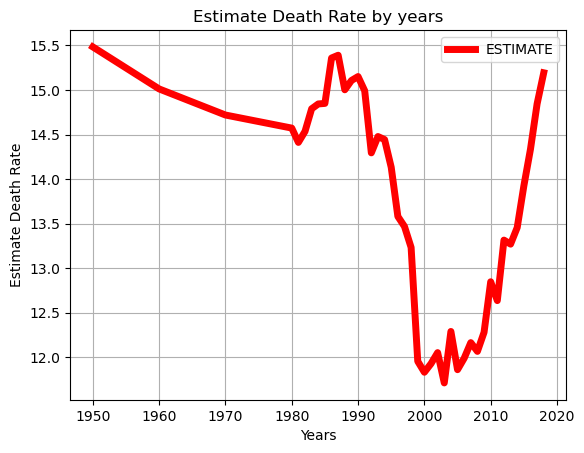

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

df.groupby("YEAR").agg({"ESTIMATE": "mean"}).plot(kind='line', color="red", linewidth=5)
plt.title('Estimate Death Rate by years')
plt.xlabel('Years')
plt.ylabel('Estimate Death Rate')
plt.grid(True)
plt.show()